# Collaborative Filtering

Kolaborativno filtriranje je tehnika kojom se ocjene filmova predvidjaju na osnovu slicnosti medju korisnicima, odnosno medju filmovima. Preporucuju se oni filmovi za koje je predvidjena ocjena najvisa.

U slucaju problema $cold$ $start$ sistemi zastovani na sadrzaju ($content-based$) su korisni, kao i kada informacije o korisnicima i proizvodima nisu dostupne. Medjutim, u poredjenju sa njima, CF pristup je siri i fleksibilniji za identifikaciju slicnih proizvoda.

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

In [7]:
from google.colab import files
import io
uploaded = files.upload()

Saving ratings.csv to ratings.csv


In [8]:
rating_df=pd.read_csv(io.BytesIO(uploaded['ratings.csv']))
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [0]:
rating_df=rating_df.sort_values('movieId')

In [11]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
81531,517,1,4.0,1487954343
30517,213,1,3.5,1316196157
81082,514,1,4.0,1533872400
30601,214,1,3.0,853937855


In [0]:
rating_df=rating_df.reset_index()

In [18]:
rating_df.head()

,index,userId,movieId,rating,timestamp
0,0,1,1,4.0,964982703
1,81531,517,1,4.0,1487954343
2,30517,213,1,3.5,1316196157
3,81082,514,1,4.0,1533872400
4,30601,214,1,3.0,853937855


In [25]:
rating_df['movieId'][5000]

168

In [0]:
svi_id=rating_df['movieId'].unique()

In [29]:
svi_id.shape

(9724,)

In [35]:
rating_df.index[rating_df['movieId']==100]#.tolist()

Int64Index([3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202,
            3203, 3204, 3205],
           dtype='int64')

In [43]:
rating_df.loc[3206] # do 3206, poslednji je 3205

index        7.991000e+04
userId       5.000000e+02
movieId      1.010000e+02
rating       1.000000e+00
timestamp    1.005528e+09
Name: 3206, dtype: float64

In [44]:
rating_df.shape

(100836, 5)

In [47]:
rating_df=rating_df[:3205] # poslednji id 100
rating_df.shape

(3205, 5)

In [0]:
svi_id100=rating_df['movieId'].unique()

In [49]:
svi_id100.shape

(89,)

In [50]:
svi_id100

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  34,  36,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  52,  53,  54,  55,  57,
        58,  60,  61,  62,  63,  64,  65,  66,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  85,  86,
        87,  88,  89,  92,  93,  94,  95,  96,  97,  99, 100])

In [51]:
svi_id.max()

193609

In [54]:
rating_df['userId'].unique().shape # 503 korisnika i 89 filmova

(503,)

In [0]:
uploaded2 = files.upload()

Saving movies.csv to movies.csv


In [0]:
movies_df=pd.read_csv(io.BytesIO(uploaded2['movies.csv']))
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
# rating_df=rating_df[:3000] # zbog brzeg pokretanja 

In [55]:
ocjene=np.linspace(rating_df.rating.min(), rating_df.rating.max(), 10)
print('Ocjene filmova:')
for o in ocjene: # moguce ocjene su 0.5, 1, 1.5, ..., 5
    print(o)

Ocjene filmova:
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0


In [56]:
n_users = rating_df.userId.unique().shape[0]
n_movies = rating_df.movieId.unique().shape[0]
print ('Ukupno: ' + str(n_users) + ' korisnika, ' + str(n_movies) + ' filma')

Ukupno: 503 korisnika, 89 filma


In [0]:
df_pivot=rating_df.pivot_table(values='rating', index='userId', columns='movieId').fillna(0)

In [0]:
ratings=df_pivot.as_matrix()

In [59]:
ratings # matrica koja sadrzi ocjene koje je i. korisnik dao j. filmu
# 0 ako korisnik nije ocjenio film

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [60]:
ratings.shape

(503, 89)

In [0]:
def sparsity(ratings): # prorjedjenost matrice
    sparsity = float(len(ratings.nonzero()[0]))
    sparsity /= (ratings.shape[0] * ratings.shape[1])
    sparsity *= 100
    return 100-sparsity

In [62]:
sparsity(ratings)

92.84070855764291

In [63]:
print ('Sparsity: {}%'.format(round(sparsity(ratings), 2)))

Sparsity: 92.84%


### Podjela na skup za obucavanje i testiranje

In [0]:
def my_train_test_split(ratings, test_size): # skupovi za obucavanje i testiranje su istog oblika, ali su vrijednsti 
    # raspodijeljene: test_size ocjena ce biti u skupu za testiranje
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    rows = (ratings != 0).sum(1)
    
    for user in range(ratings.shape[0]):
        count_per_user=int(np.ceil(test_size*rows[user]))
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], # 0 jer je nonzero primjenjeno na vektor
                                        size=count_per_user,  # indexi na kojima nisu 0
                                        replace=False)
        # u skup za obucavanje se upisuju 0 na izabranim pozicijama, a u skup za testiranje se upisuju elementi 
        train[user, test_ratings] = 0
        test[user, test_ratings] = ratings[user, test_ratings] 
        
    # provjera da li su poznate ocjene ili u jednom ili u drugom skupu
    assert(np.all((train * test) == 0)) 
    return train, test

In [0]:
train, test = my_train_test_split(ratings, 0.2)

In [66]:
sparsity(train)

94.84665043447183

In [67]:
train.shape # skupovi za obucavanje i testiranje su istih dimenzija, s tim sto im je proredjenost drugacija

(503, 89)

In [68]:
test.shape

(503, 89)

In [69]:
sparsity(test)

97.99405812317109

# Item-based Collaborative Filtering

In [0]:
def movies_similarity(ratings, epsilon=1e-9):
    # dodaje se epsilon -> mala vrijednost u slucaju da je slicnost filmova 0
    return cosine_similarity(ratings.T)+epsilon

In [0]:
m_sim=movies_similarity(train)

In [0]:
def predict_movies_top_k(ratings, movies_similarity, k=10):
    pred = np.zeros(ratings.shape)
    for j in range(ratings.shape[1]):
        top_k_items=[np.argsort(movies_similarity)[j][::-1][1:k+1]]
       
        for i in range(ratings.shape[0]):
            pred[i, j] = movies_similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
            pred[i, j] /= np.sum(np.abs(movies_similarity[j, :][top_k_items]))        
    
    return pred

In [0]:
m_pred=predict_movies_top_k(train, m_sim)

# User-based Collaborative Filtering

In [0]:
def users_similarity(ratings, epsilon=1e-9):
    return cosine_similarity(ratings)+epsilon

In [75]:
u_sim=users_similarity(train)
u_sim.shape

(503, 503)

In [0]:
def predict_users_top_k(ratings, users_similarity, k=10):
    pred = np.zeros(ratings.shape)

    for i in range(ratings.shape[0]):
        top_k_users=[np.argsort(users_similarity[:,i])[::-1][1:k]]
        #print(top_k_users)
        for j in range(ratings.shape[1]):
            pred[i,j]=ratings[:, j][top_k_users].mean()
    
    return pred

In [0]:
u_pred=predict_users_top_k(train, u_sim)

### Validacija

In [0]:
def get_rmse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

In [0]:
def get_mae(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_absolute_error(pred, actual)

In [80]:
print ('Item-based CF RMSE train: {}'.format(get_rmse(m_pred, train)))
print ('Item-based CF RMSE test: {}'.format(get_rmse(m_pred, test)))

print ('Item-based CF MAE train: {}'.format(get_mae(m_pred, train)))
print ('Item-based CF MAE test: {}'.format(get_mae(m_pred, test)))

Item-based CF RMSE train: 2.6127641325891133
Item-based CF RMSE test: 2.9740306913899843
Item-based CF MAE train: 2.349875975524772
Item-based CF MAE test: 2.7202465372847824


In [81]:
print ('User-based CF RMSE train: {}'.format(get_rmse(u_pred, train)))
print ('User-based CF RMSE test: {}'.format(get_rmse(u_pred, test)))

print ('User-based CF MAE train: {}'.format(get_mae(u_pred, train)))
print ('User-based CF MAE test: {}'.format(get_mae(u_pred, test)))

User-based CF RMSE train: 2.0922046985600984
User-based CF RMSE test: 3.2584532628448493
User-based CF MAE train: 1.7828107691566732
User-based CF MAE test: 3.0757238307349666


### Izbor vrijednosti za $k$ najblizih susjeda

In [0]:
k_array = [10, 20, 50, 100]

u_train_mae = []
u_test_mae = []
m_test_mae = []
m_train_mae = []

for k in k_array:
    u_pred = predict_users_top_k(train, u_sim, k=k)
    m_pred = predict_movies_top_k(train, m_sim, k=k)
    
    u_train_mae += [get_mae(u_pred, train)]
    u_test_mae += [get_mae(u_pred, test)]
    
    m_train_mae += [get_mae(m_pred, train)]
    m_test_mae += [get_mae(m_pred, test)] 

Text(0, 0.5, 'MSE')

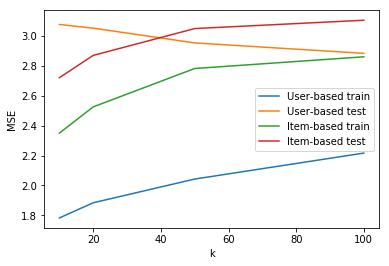

In [83]:
plt.plot(k_array, u_train_mae, label='User-based train')
plt.plot(k_array, u_test_mae, label='User-based test')
plt.plot(k_array, m_train_mae, label='Item-based train')
plt.plot(k_array, m_test_mae, label='Item-based test')
plt.legend(loc='best')
plt.xlabel('k')
plt.ylabel('MSE')

# Singular Value Decomposition

In [0]:
U, sigma, Vt = svds(train, k = 3) # k singularnih vrijednosti i vektora
sigma=np.diag(sigma)

### Predvidjanje ocjena na osnovu dekomponovane matrice

In [0]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt)

In [86]:
print ('SVD CF MAE train: {}'.format(get_mae(predicted_ratings, train)))
print ('SVD CF MAE test: {}'.format(get_mae(predicted_ratings, test)))

SVD CF MAE train: 2.255411044344546
SVD CF MAE test: 2.9325428241303944


In [0]:
k_array = [1, 3, 5] # broj singularnih vrijednosti i vektora

train_mae = []
test_mae = []

for k in k_array:
    
    U, sigma, Vt = svds(train, k = k)
    sigma=np.diag(sigma)
    
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
    
    train_mae += [get_mae(all_user_predicted_ratings, train)]
    test_mae += [get_mae(all_user_predicted_ratings, test)]


Text(0, 0.5, 'MSE')

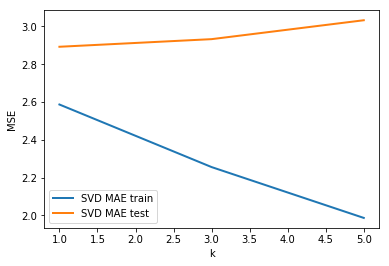

In [88]:
plt.plot(k_array, train_mae, label='SVD MAE train', linewidth=2)
plt.plot(k_array, test_mae, label='SVD MAE test', linewidth=2)
plt.legend(loc='best', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('k', fontsize=10)
plt.ylabel('MSE', fontsize=10)

### Preporuka filmova

In [89]:
preds_df = pd.DataFrame(predicted_ratings, columns = df_pivot.columns)
preds_df.shape

(503, 89)

In [0]:
def recommend_movies(predictions_df, userId, movies_df, original_ratings_df, num_recommendations=5):
    
    # sortiranje predvidjenih ocjena filmova 
    user_row_number = userId - 1 # indeksiranje userId pocinje od 1
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # uzimanje podataka o korisniku iz polazne podataka
    user_data = original_ratings_df[original_ratings_df.userId == (userId)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False))

    print ('Broj filmova koje je korisnik {0} vec ocjenio: {1}'.format(userId, user_full.shape[0]))
    print ('Broj neocjenjenih filmova za koje su predvidjene najvise ocjene: {0}'.format(num_recommendations))
    
    # preporuka neocjenjenih filmova za koje su predvidjene najvise ocjene
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [91]:
already_rated, predictions = recommend_movies(preds_df, 1, movies_df, rating_df, 5)

NameError: ignored

In [0]:
already_rated.head()

,userId,movieId,rating,timestamp,title,genres
231,1,5060,5.0,964984002,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War
185,1,2872,5.0,964981680,Excalibur (1981),Adventure|Fantasy
89,1,1291,5.0,964981909,Indiana Jones and the Last Crusade (1989),Action|Adventure
90,1,1298,5.0,964984086,Pink Floyd: The Wall (1982),Drama|Musical
190,1,2948,5.0,964982191,From Russia with Love (1963),Action|Adventure|Thriller


In [0]:
predictions

,movieId,title,genres
642,904,Rear Window (1954),Mystery|Thriller
1896,2762,"Sixth Sense, The (1999)",Drama|Horror|Mystery
764,1086,Dial M for Murder (1954),Crime|Mystery|Thriller
1498,2186,Strangers on a Train (1951),Crime|Drama|Film-Noir|Thriller
874,1259,Stand by Me (1986),Adventure|Drama


# Implementacija metoda Stohasticki gradijentni spust

Metod latentnih faktora za CF, koji se moze sprovesti pomocu stohastickog gradijentnog spusta, koristi postojece ocjene filmova kako bi naucio istovremeno latentne karakteristike i korisnika i filmova. Ovo je dosta mocniji pristup u poredjenju sa metodom najblizih susjeda.

In [0]:
# Root Mean Squared Error
def rmse_sgd(train, Q, P):
    I = train != 0  # indikatorska funkcija o ocjenjenim filmovima
    ME = I * (train - np.dot(P, Q.T))  # greska izmedju stvarnih i predvidjenih vrijednosti
    MSE = ME**2  
    return np.sqrt(np.sum(MSE)/np.sum(I)) 

In [0]:
# parametri i inicijalizacija latentnih faktora
f = 5  # broj parova latentnih faktora
lmbda = 0.5 # Regularisation strength
gamma=0.01  # Learning rate
n_epochs = 10  # Number of loops through training data
P = np.sqrt(train.max())* np.random.rand(n_users, f) # Latentni faktori za korisnika
Q = np.sqrt(train.max())* np.random.rand(n_movies, f) # Latentni faktori za filmove

In [0]:
# SGD
train_errors_per_epochs = []
test_errors_per_epochs = []
users,items = train.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = train[u, i] - np.dot(P[u, :], Q[i, :].T)  # greska kao razlika poznate i pretpostavljene ocjene
        P[u, :] += gamma * ( e * Q[i, :] - lmbda * P[u, :]) # azuriranje nove vrijednosti koja opisuje koristika
        Q[i, :] += gamma * ( e * P[u, :] - lmbda * Q[i, :])  # azuriranje nove vrijednosti koja opisuje film
    train_errors_per_epochs.append(rmse_sgd(train,Q,P)) # Training RMSE for this pass
    test_errors_per_epochs.append(rmse_sgd(test,Q,P)) # Test RMSE for this pass

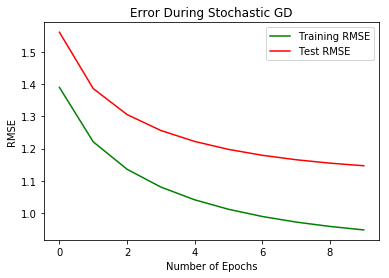

In [95]:
# provjeravanje performansi grafickim prikazom greske na skupu za obucavanje i testiranje
plt.plot(train_errors_per_epochs, color="g", label='Training RMSE')
plt.plot(test_errors_per_epochs, color="r", label='Test RMSE')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.title('Error During Stochastic GD')
plt.legend()
# Tokom procesa obucavanja, greska na skupu za obucavanje ima trend opadanja

In [96]:
predicted_train=np.dot(P, Q.T)
predicted_train

array([[3.0160606 , 2.74967348, 2.68746557, ..., 3.19514963, 5.47908431,
        2.61613743],
       [4.63098833, 4.22406483, 4.10752697, ..., 4.60354745, 8.14994295,
        4.52396245],
       [2.66558252, 2.21384199, 2.39126058, ..., 2.71624258, 4.06632349,
        2.55034617],
       ...,
       [2.47419764, 2.11495539, 2.06404923, ..., 2.05912299, 3.44530882,
        2.14234261],
       [2.29226407, 2.20235174, 2.05575672, ..., 2.28429807, 4.24142525,
        1.71589468],
       [4.31616769, 3.93124954, 3.69691288, ..., 3.55748322, 6.62888047,
        3.80230193]])

In [97]:
print('SVD CF MAE train: {}'.format(get_mae(predicted_train, train)))
print('SVD CF RMSE train: {}'.format(get_rmse(predicted_train, train)))

SVD CF MAE train: 0.7645828564729992
SVD CF RMSE train: 0.9465509687914679


### Validacija na test skupu

In [0]:
f = 5  # broj parova latentnih faktora
lmbda = 0.5 # Regularisation strength
gamma=0.01  # Learning rate
n_epochs = 10  
P = np.sqrt(test.max())* np.random.rand(n_users, f) # Latentni faktori za korisnika
Q = np.sqrt(test.max())* np.random.rand(n_movies, f) 

In [0]:
# SGD na test skupu
users,items = test.nonzero()      
for epoch in range(n_epochs):
    for u, i in zip(users,items):
        e = test[u, i] - np.dot(P[u, :], Q[i, :].T)  
        P[u, :] += gamma * ( e * Q[i, :] - lmbda * P[u, :]) 
        Q[i, :] += gamma * ( e * P[u, :] - lmbda * Q[i, :]) 

In [100]:
predicted_test=np.dot(P, Q.T)
predicted_test

array([[3.67235655, 3.36959755, 4.737291  , ..., 5.59169627, 6.04716199,
        6.2764838 ],
       [2.6893963 , 2.68017526, 3.02560448, ..., 4.28928704, 4.67179067,
        4.09273527],
       [3.36091334, 3.08825136, 4.35176677, ..., 3.78345648, 4.99733402,
        5.49634446],
       ...,
       [2.59892048, 2.33240605, 2.04566803, ..., 4.3647401 , 5.31385801,
        3.03881858],
       [2.78324263, 2.73717127, 3.04446871, ..., 5.84652839, 5.27833125,
        4.91742676],
       [2.76021024, 2.36729588, 2.10667567, ..., 4.36182991, 5.72709206,
        2.88626585]])

In [101]:
print('SVD CF MAE test: {}'.format(get_mae(predicted_test, test)))
print('SVD CF RMSE test: {}'.format(get_rmse(predicted_test, test)))

SVD CF MAE test: 0.765513216375061
SVD CF RMSE test: 0.9519615948868037
